https://github.com/IlliaOvcharenko/lung-segmentation

# First fine tune based on self feedback and scores. Updated model saved as model1_1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master')

In [ ]:
import torch
import torchvision
import glob
import time
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice
import torch.nn.functional as F

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
import pdb

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data loading

In [ ]:
class CXRDataset(Dataset):
    def __init__(self, csv_file, cxr_dir, mask_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.cxr_dir = cxr_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        folder_name = self.data_frame.iloc[idx, 0]
        cxr_name = self.data_frame.iloc[idx, 1]
        cxr_path = os.path.join(self.cxr_dir, folder_name, cxr_name)
        #mask_name = cxr_name.split('.')[0] + '.jpg'  # Assuming mask files have the same name as the corresponding image files
        mask_name = cxr_name
        mask_path = os.path.join(self.mask_dir, folder_name, mask_name)

        image = Image.open(cxr_path).convert('L') #--> image value in range [0,1]
        mask = Image.open(mask_path).convert('L') #--> mask value in range [0,1]

        if self.transform:
            image = self.transform(image)
            resized_mask = self.transform(mask)
            threshold = 0.5
            binary_mask = (resized_mask > threshold).float()
        return image, binary_mask

# Example usage:
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors
    # transforms.Normalize((0.5, 0.5), (0.5, 0.5))  # Normalize image tensors
])
csv_path = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/filtered_self_feedback.csv'
cxr_dir = '/content/drive/Shareddrives/PulSAR-AI/Images'
mask_dir = '/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/mask'

dataset = CXRDataset(csv_path, cxr_dir, mask_dir, transform=data_transform)
batch_size = 8

# # Split the dataset into train and validation sets
# train_ratio = 0.8  # Percentage of data for training
# train_size = int(train_ratio * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# # Create data loaders for train and validation sets
# train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers = 2,shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers = 2,shuffle=False)

train_loader = DataLoader(dataset, batch_size=batch_size, num_workers = 2,shuffle=True)

## Check dataloading

tensor([[[0.8471, 0.8471, 0.8471,  ..., 0.8471, 0.8471, 0.8471],
         [0.5725, 0.5725, 0.5725,  ..., 0.5725, 0.5725, 0.5725],
         [0.1490, 0.1490, 0.1490,  ..., 0.1804, 0.2235, 0.1569],
         ...,
         [0.1216, 0.1451, 0.0824,  ..., 0.4510, 0.3647, 0.0196],
         [0.1216, 0.1490, 0.0706,  ..., 0.4392, 0.3529, 0.0196],
         [0.2078, 0.2235, 0.1725,  ..., 0.3922, 0.3490, 0.1529]]])
torch.Size([1, 256, 256])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 256, 256])
(256, 256, 1)
(256, 256)


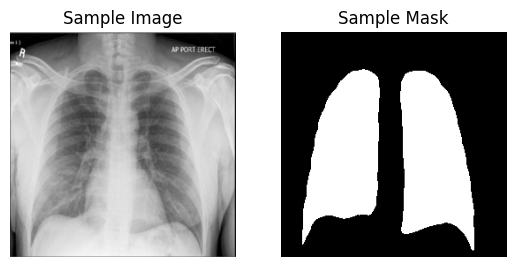

In [ ]:
import matplotlib.pyplot as plt

dataloader_check = DataLoader(dataset, batch_size=1, shuffle=True)

# Iterate over the data loader to get the first batch (size = 1)
for images, masks in dataloader_check:
    sample_image = images[0]  # Extract the first image from the batch --> image value in range [0,1]
    sample_mask = masks[0]  # Extract the corresponding mask --> mask value in range [0,1]
    print(sample_image)
    print(sample_image.shape)
    print(sample_mask)
    print(sample_mask.shape)

    # Convert tensor to numpy array
    sample_image = sample_image.permute(1, 2, 0).numpy()
    sample_mask = sample_mask.squeeze().numpy()
    print(sample_image.shape)

    print(sample_mask.shape)

    # Denormalize the image (if it was normalized in the transforms)
    # sample_image = sample_image * 0.5 + 0.5

    # Plot the sample image and mask
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Sample Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask, cmap='gray')
    plt.title('Sample Mask')
    plt.axis('off')

    plt.show()
    break  # Stop after processing the first batch


## Model training

In [ ]:
# unet = UNet(in_channels=1, out_channels=2, batch_norm=True)
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)
unet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:03<00:00, 174MB/s]


PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

In [ ]:
model_name = "unet-model1.pt"
unet.load_state_dict(torch.load("/content/drive/MyDrive/Projects/Pulsar-AI/saved_models/model1.pt", map_location=torch.device("cpu")))
unet = unet.to(device)
# optimizer = torch.optim.SGD(unet.parameters(), lr=0.0005, momentum=0.9)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.0005)

In [ ]:
train_log_filename = "train-log-fine_tune.txt"
epochs = 3
best_val_loss = np.inf
best_train_loss = np.inf
model_name = "unet-6v.pt"

In [ ]:
hist = []

for e in range(epochs):
    start_t = time.time()

    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in train_loader:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outs = unet(origins)
        # pdb.set_trace()
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        loss = torch.nn.functional.nll_loss(softmax, masks.squeeze(1).long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * num
        print(".", end="")

    train_loss = train_loss / len(dataset)
    if train_loss < best_train_loss:
          best_train_loss = train_loss
          torch.save(unet.state_dict(), '/content/drive/MyDrive/Projects/Pulsar-AI/saved_models/model1_1.pt')
          print("model saved")
          # train_log_file.write("model saved\n")
    print("train_loss = ", train_loss)
    print("best train_loss = ", best_train_loss)
    print()


    # print("validation phase")
    # unet.eval()
    # val_loss = 0.0
    # val_jaccard = 0.0
    # val_dice = 0.0

    # for origins, masks in val_loader:
    #     num = origins.size(0)

    #     origins = origins.to(device)
    #     masks = masks.to(device)

    #     with torch.no_grad():
    #         outs = unet(origins)
    #         softmax = torch.nn.functional.log_softmax(outs, dim=1)
    #         val_loss += torch.nn.functional.nll_loss(softmax, masks.squeeze(1).long()).item() * num

    #         outs = torch.argmax(softmax, dim=1)
    #         outs = outs.float()
    #         masks = masks.float()
    #         val_jaccard += jaccard(masks.squeeze(1).long(), outs.float()).item() * num
    #         val_dice += dice(masks.squeeze(1).long(), outs).item() * num

    #     print(".", end="")
    # val_loss = val_loss / len(val_dataset)
    # val_jaccard = val_jaccard / len(val_dataset)
    # val_dice = val_dice / len(val_dataset)
    # print()


    # end_t = time.time()
    # spended_t = end_t - start_t

    # with open(train_log_filename, "a") as train_log_file:
    #     report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
    #            + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

    #     hist.append({
    #         "time": spended_t,
    #         "train_loss": train_loss,
    #         "val_loss": val_loss,
    #         "val_jaccard": val_jaccard,
    #         "val_dice": val_dice,
    #     })

    #     print(report)
    #     train_log_file.write(report + "\n")

    #     if val_loss < best_val_loss:
    #         best_val_loss = val_loss
    #         torch.save(unet.state_dict(), '/content/drive/MyDrive/Projects/Pulsar-AI/saved_models/model1_1.pt')
    #         print("model saved")
    #         train_log_file.write("model saved\n")
    #     print()


train phase
.............................................model saved
train_loss =  0.01862133118427462
best train_loss =  0.01862133118427462

train phase
.............................................model saved
train_loss =  0.013446664416955577
best train_loss =  0.013446664416955577

train phase
.............................................train_loss =  0.014231298553446929
best train_loss =  0.013446664416955577



In [ ]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig("/content/drive/MyDrive/Projects/Pulsar-AI/output/model1_1/train-hist.png")

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

## Evaluate

In [ ]:
unet = PretrainedUNet(1, 2, True, "bilinear")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
 11%|█         | 54.3M/507M [00:01<00:10, 44.5MB/s]


KeyboardInterrupt: ignored

In [ ]:
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load("/content/drive/MyDrive/Projects/Pulsar-AI/saved_models/model1_1.pt", map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [ ]:
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

for origins, masks in val_loader:
    num = origins.size(0)

    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        test_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

        outs = torch.argmax(softmax, dim=1)
        outs = outs.float()
        masks = masks.float()
        test_jaccard += jaccard(masks, outs).item() * num
        test_dice += dice(masks, outs).item() * num
    print(".", end="")

test_loss = test_loss / val_size
test_jaccard = test_jaccard / val_size
test_dice = test_dice / val_size

print()
print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

RuntimeError: ignored

In [ ]:
num_samples = 9
phase = "test"

subset = torch.utils.data.Subset(
    datasets[phase],
    np.random.randint(0, len(datasets[phase]), num_samples)
)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)
plt.figure(figsize=(20, 25))

for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx+1)

    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        jaccard_score = jaccard(mask.float(), out.float()).item()
        dice_score = dice(mask.float(), out.float()).item()

        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        mask = mask[0].to("cpu")

        plt.imshow(np.array(blend(origin, mask, out)))
        plt.title(f"jaccard: {jaccard_score:.4f}, dice: {dice_score:.4f}")
        print(".", end="")

plt.savefig(images_folder / "obtained-results.png", bbox_inches='tight')
print()
print("red area - predict")
print("green area - ground truth")
print("yellow area - intersection")

## Inference


In [ ]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)

In [ ]:
model_name = "unet-model1_1.pt"
unet.load_state_dict(torch.load("/content/drive/MyDrive/Projects/Pulsar-AI/saved_models/model1_1.pt", map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

## Inference on CCF data

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/CCF_COVID" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend_ft1/CCF_COVID" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  #if file_extension == ".png":
  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  origin1 = Image.open(image_path).convert("RGB")
  origin1 = torchvision.transforms.functional.to_tensor(origin1)
  height = origin1.shape[1]
  width = origin1.shape[2]

  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)
      origin = origin[0].to("cpu")
      out = out[0].to("cpu")
      out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
      threshold = 0.5
      out_upsample = (out_upsample > threshold).float()
      out_reshape = torch.permute(out_upsample,(1,2,0))
      out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
      origin_reshape = torch.permute(origin1,(1,2,0))
      segmented_lung = out_reshape1 * origin_reshape

      transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
      origin_blend = transform(origin_reshape.permute(2,0,1))
      out_reshape1[:,:,0] = 0
      out_reshape1[:,:,2] = 0
      mask_blend = transform(out_reshape1.permute(2,0,1))
      origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
      save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
      origin_blend.save(save_path)



100%|██████████| 1117/1117 [06:59<00:00,  2.66it/s]
